In [3]:
import SimpleITK as sitk
from PIL import Image, ImageOps
import matplotlib.pylab as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.filters import roberts
from scipy import ndimage as ndi
from skimage.segmentation import clear_border
from sklearn.preprocessing import minmax_scale
from skimage.transform import resize
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import PIL
import cv2
import skimage
import pickle

In [ ]:
input_images = []

In [285]:
def preprocess_kaggle(ct_scan_loc):
    # get image and pull origin and spacing for translating nodule coordinates from file
    ct_scan = Image.open(ct_scan_loc)
    # ct_scan = Image.open("cancer_data\Bengin cases\Bengin case (" + str(x) + ").jpg")
    ct_scan = ImageOps.grayscale(ct_scan)
    ct_scan = np.array(ct_scan)
    # blur image
    # ct_scan_thresh_mask = gaussian_filter(ct_scan, sigma=(1, 1))
    ct_scan_thresh_mask = ct_scan
    # ct_scan_thresh_mask = ct_scan_thresh_mask < 175
    # x+=1

    # not in hounsfield units
    # range of tissue and bronchioles to keep: study doesn't give exact number (close to -1000 or above -320 masked)
    min_hu = 100 #100
    max_hu = 175 #175
    ct_scan_thresh_mask = np.clip(ct_scan_thresh_mask, min_hu, max_hu)
    
    #######################################################################################################
    ##https://www.kaggle.com/code/arnavkj95/candidate-generation-and-luna16-preprocessing/notebook########
    ##### preprocessing ideas taken from the above website ###############################################
    #######################################################################################################
    ct_scan_thresh_mask = clear_border(ct_scan_thresh_mask)
    #######################################################################################################
    ##### End preprocesing ideas########################### ###############################################
    #######################################################################################################
    
    # set paramters for blob detector
    params = cv2.SimpleBlobDetector_Params()
    params.filterByInertia = False
    params.filterByConvexity = False
    params.filterByColor = True
    params.blobColor = 255
    params.filterByArea = True
    params.maxArea = 1000
    params.minArea = 0

    kernel = np.ones((1,1),np.uint8)
    ct_scan_thresh_mask = cv2.erode(ct_scan_thresh_mask,kernel,iterations = 1)
    
    #detect blobs
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(ct_scan_thresh_mask)
    im_with_keypoints = cv2.drawKeypoints(ct_scan_thresh_mask, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.imshow("Keypoints", im_with_keypoints)
    
    #obtain keypoints and diameters
    keypoint_list = []
    for i in keypoints:
        x_loc = i.pt[0]
        y_loc = i.pt[1]
        size = i.size #diameter of blob
        keypoint_list.append([x_loc, y_loc,size])
    # will use format for boxes im_with_keypoints[ymin:ymax, xmin:xmax]
    # set boxes to 1
    zeros = np.zeros(ct_scan_thresh_mask.shape)
    for i in keypoint_list:
        range_val = np.ceil(i[2])
        zeros[int(i[1]-range_val):int(i[1]+range_val), int(i[0]-range_val):int(i[0]+range_val)] = 1

    # assign masked regions to original ct
    ct_scan[zeros == 0] = 0
    ct_scan[ct_scan < 110] = 0

    # Need to normal 0-1 and zero_center
    ct_scan = minmax_scale(ct_scan, feature_range=(0, 1))

    # 3d spline interpolation to 0.5 in xyz directions
    ct_scan = resize(ct_scan, (256, 256), mode="reflect")

    # zero mean to make data symmetric
    meanCenter = lambda x: x - x.mean()
    ct_scan = meanCenter(ct_scan)
    return ct_scan


def top_nodules(image):
    # 32x32 window
    #get sums of windows
    image = resize(image, (256, 256), mode="reflect")
    min_x, max_x=0,32
    sums = []
    while max_x < image.shape[0]:
        min_y, max_y = 0,32
        while max_y < image.shape[1]:
            sum_window = sum(sum(image[min_x:max_x,min_y:max_y]))[0]
            sums.append([sum_window, min_x, max_x, min_y, max_y])
            min_y+=1
            max_y+=1
        min_x+=1
        max_x+=1
    # sort by sum
    sums = sorted(sums, reverse=True, key=lambda x: x[0])
    
    #get only top sums that don't overlap
    final_sums = []
    for i in sums:
        if len(final_sums) < 4:
            if len(final_sums)==0:
                final_sums.append(i)
                continue
            else:
                included = 0
                for j in final_sums:
                    if (abs(i[1] - j[1]) < 32) & (abs(i[3] - j[3]) < 32):
                        included = 1
                if included == 0:
                    final_sums.append(i)

        else:
            break
            
    #concatentate top 4 windows
    cancer_input = np.concatenate((image[final_sums[0][1]:final_sums[0][2],final_sums[0][3]:final_sums[0][4]],image[final_sums[1][1]:final_sums[1][2],final_sums[1][3]:final_sums[1][4]]), axis=1)
    cancer_input2 = np.concatenate((image[final_sums[2][1]:final_sums[2][2],final_sums[2][3]:final_sums[2][4]],image[final_sums[3][1]:final_sums[3][2],final_sums[3][3]:final_sums[3][4]]), axis=1)
    cancer_input_concat = np.concatenate((cancer_input, cancer_input2), axis=0)
    return cancer_input_concat
    
    
def train_model(X_train, y_train):
    #############################################################################################################################################################
    ############### Code mostly taken from DigitalSreeni at https://www.youtube.com/watch?v=GAYJ81M58y8 ################################################################
    ############### Using this code as it matches the U-Net model needed, with updates to parameters and the addition of dropout layers #################
    ##############################################################################################################################################################
    from tensorflow.keras.utils import normalize
    from tensorflow.keras.optimizers import Adam
    from keras.layers import (
        Conv2D,
        MaxPooling2D,
        Input,
        UpSampling2D,
        Dropout,
        concatenate,
        Dense,
        Flatten
    )
    from keras.models import Model

    # convolutions
    inputs = Input((64, 64, 1))
    s1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    s2 = Conv2D(64, 3, activation="relu", padding="same")(s1)
    p1 = MaxPooling2D(pool_size=(2, 2))(s2)
    s3 = Dropout(0.2)(p1)
    s4 = Conv2D(128, 3, activation="relu", padding="same")(s2)
    p2 = MaxPooling2D(pool_size=(2, 2))(s4)
    s5 = Dropout(0.2)(p2)
    s6 = Conv2D(64, 3, activation="relu", padding="same")(s5)
    s7 = Conv2D(64, 3, activation="relu", padding="same")(s6)
    f1 = Flatten()(s7)
    outputs = Dense(1, activation="sigmoid")(f1)

    model = Model(inputs, outputs, name="cancer_model")

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()

    ############################################################################################
    ########## end code taken from DigitalSreeni ###############################################
    ###################### at https://www.youtube.com/watch?v=GAYJ81M58y8#######################
    ############################################################################################

    # get top 8 suspicious non-overlapping regions for cancer/non-cancer

    from keras.callbacks import ModelCheckpoint
    from sklearn.metrics import accuracy_score, recall_score, precision_score

    # fit model and show results of each epoch
    checkpoint_name = "Weights-{epoch:03d}--{val_loss:.5f}.hdf5"
    checkpoint = ModelCheckpoint(
        checkpoint_name, monitor="val_loss", verbose=1, save_best_only=True, mode="auto"
    )
    callbacks_list = [checkpoint]
    #train model
    model.fit(X_train, y_train, epochs=10, batch_size=5, callbacks=callbacks_list, validation_split=0.1,)
    return model



In [264]:
#get all images adn save their labels
folders = [
        "cancer_data/Bengin cases/",
        "cancer_data/Malignant cases/",
    ]
images=[]
for folder in folders:
    print('checking folder: ', folder)
    files = os.listdir(folder)
    
    for file in files:
        
        image_loc = str(folder) + str(file)
        image = preprocess_kaggle(image_loc)
        if folder == "cancer_data/Bengin cases/":
            images.append([image, 0])
        else:
            images.append([image, 1])
print("images imported")

# import model
model = tf.keras.models.load_model('model_0503TF_2')
print("model imported")

#get list of all input images and get nodules       
input_images = [i[0] for i in images]
np_input = np.array(input_images)
np_input = np_input.reshape(len(np_input), 256, 256, 1)
pred_NN = model.predict(np_input)
print("nodule candidates found")

#get all nodules
quad_nodules = []
x=0
while x < len(pred_NN):
    quad = top_nodules(pred_NN[x])
    cancer = images[x][1]
    quad_nodules.append([quad, cancer])
    x+=1
print("nodule candidates ready for training")


# separate into train and test sets
np.random.shuffle(quad_nodules)
test_set = []
no=0
yes=0
while (yes < 110) | (no < 40):
    if yes < 110:
        x=0
        while x < len(quad_nodules):
            if quad_nodules[x][1] == 1:
                pop = quad_nodules.pop(x)
                test_set.append(pop)
                yes+=1
                break
            x+=1
    if no < 40:
        x=0
        while x < len(quad_nodules):
            if quad_nodules[x][1] == 0:
                pop = quad_nodules.pop(x)
                test_set.append(pop)
                no+=1
                break
            x+=1
            



nodule candidates ready for training


In [267]:
#save for use later in case needed
filename = "quad_nodules.sav"
pickle.dump(quad_nodules, open(filename, "wb"))
filename = "test_set_nodules.sav"
pickle.dump(test_set, open(filename, "wb"))

# get input and outputs
quad_nodules_x = [i[0] for i in quad_nodules]
quad_nodules_y = [i[1] for i in quad_nodules]

In [286]:
#convert to numpu arrays and train model
quad_nodules_x = np.array(quad_nodules_x)
# quad_nodules_x = np_input.reshape(len(quad_nodules_x), 64, 64, 1)
quad_nodules_y = np.array(quad_nodules_y)
# quad_nodules_y = np_input.reshape(len(quad_nodules_y), 1)
cancer_model = train_model(quad_nodules_x, quad_nodules_y)

Model: "cancer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 32, 32, 128)       0         
                                                      

In [287]:
# test on test set
# get input and outputs
test_nodules_x = [i[0] for i in test_set]
test_nodules_y = [i[1] for i in test_set]

#predict on test set
test_nodules_x = np.array(test_nodules_x)
test_results = cancer_model.predict(test_nodules_x)

# save test set to a dataframe
result_df = pd.DataFrame(test_results)
result_df.columns=['probability']
result_df['actual'] = test_nodules_y

# chose 80% as cutoff for prediction - could move either way to increase/decrease FP and FN
result_df['prediction'] = 0
result_df.loc[result_df['probability']>=0.8,'prediction'] = 1

In [321]:
# calculate metrics
accuracy = len(result_df[result_df['prediction'] == result_df['actual']]) / len(result_df)
tp = len(result_df[(result_df['prediction'] == 1) & (result_df['actual'] == 1)])
precision = tp / (tp + len(result_df[(result_df['prediction'] == 1) & (result_df['actual'] == 0)]))
tp = len(result_df[(result_df['prediction'] == 1) & (result_df['actual'] == 1)])
recall = tp / (tp + len(result_df[(result_df['prediction'] == 0) & (result_df['actual'] == 1)]))
#use f1 since classes are of different sizes
f1 = 2 * (precision * recall) / (precision + recall)
fn =  len(result_df[(result_df['prediction'] == 0) & (result_df['actual'] == 1)]) 
fnr = fn / (fn + len(result_df[(result_df['prediction'] == 1) & (result_df['actual'] == 1)]) )
fp =  len(result_df[(result_df['prediction'] == 1) & (result_df['actual'] == 0)]) 
fpr = fp / (fp + len(result_df[(result_df['prediction'] == 0) & (result_df['actual'] == 0)]) ) 
print('Accuracy: ', accuracy)
print('Precision: ', precision) 
print('Recall: ', recall)     
print('F1: ', f1)
print('False Negative: ', fnr)
print('False Positive: ', fpr)

Accuracy:  0.6733333333333333
Precision:  0.8426966292134831
Recall:  0.6818181818181818
F1:  0.7537688442211055
False Negative:  0.3181818181818182
False Positive:  0.35


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  4.,  7.,  8.,
         2.,  9.,  7., 10.,  8., 10., 41.]),
 array([0.15464914, 0.19691667, 0.23918422, 0.28145176, 0.3237193 ,
        0.36598682, 0.40825436, 0.4505219 , 0.49278945, 0.53505695,
        0.5773245 , 0.6195921 , 0.6618596 , 0.70412713, 0.74639463,
        0.7886622 , 0.83092976, 0.87319726, 0.9154648 , 0.9577323 ,
        0.9999999 ], dtype=float32),
 <BarContainer object of 20 artists>)

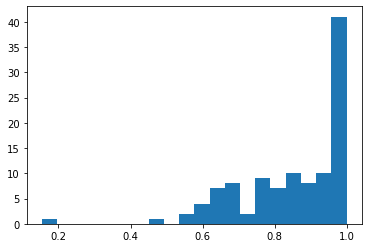

In [302]:
plt.hist(result_df['probability'][result_df['actual'] == 1], bins=20)

(array([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 4., 5., 7., 3., 3., 1.,
        1., 2., 8.]),
 array([0.12021066, 0.16420005, 0.20818946, 0.25217885, 0.29616824,
        0.34015763, 0.38414705, 0.42813644, 0.47212583, 0.51611525,
        0.5601046 , 0.604094  , 0.6480834 , 0.6920728 , 0.73606217,
        0.7800516 , 0.824041  , 0.86803037, 0.9120198 , 0.95600915,
        0.99999857], dtype=float32),
 <BarContainer object of 20 artists>)

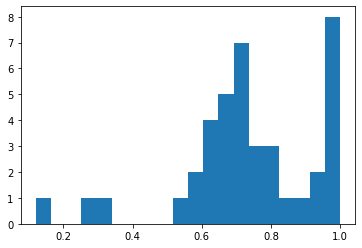

In [300]:
plt.hist(result_df['probability'][result_df['actual'] == 0], bins=20)